<a href="https://colab.research.google.com/github/PaiwandAlAhmady/RoboCup-Work_Object-Segmentation-Model/blob/main/Trained_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Datenannotation vom Datensatz

Dieses Notebook wurde verwendet um den Trainingsdatensatz mit Polygonmasken zu versehen:

1. Polygonmasken mit Roboflow Annotation erstellen
2. Leichtes Modell trainieren mit yolo11n-seg
3. Statt COCO Modell, YOLO Modell verwenden und mit SAM2 Bilddaten segmentieren
4. Neuen DAtensatz bereinigen und wiederholen bis ein robustes Modell entsteht und der Großteil der Daten gelabelt ist


In [ ]:
# Check GPU
!nvidia-smi

# Fresh environment
!pip -q install -U ultralytics opencv-python shapely

Sat Sep 20 15:19:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

ValueError: mount failed

In [ ]:
yolo task=segment mode=train model=yolo11n-seg.pt data=/content/drive/MyDrive/Roboflow_DataSet/data.yaml epochs=100 imgsz=640 batch=16
# weights at runs/segment/train/weights/best.pt

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Roboflow_DataSet/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

In [ ]:
!pip -q install -U ultralytics opencv-python shapely

In [ ]:
from ultralytics.data.annotator import auto_annotate

auto_annotate(
    data="/content/drive/MyDrive/sam2_dataset/images/train",
    det_model="/content/runs/segment/train4/weights/best.pt",  # your trained model
    sam_model="sam2_b.pt",
    conf=0.35   # optional: adjust if you get too many/too few detections
)


image 1/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094054.jpg: 640x480 1 Kugellager, 57.5ms
image 2/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094457.jpg: 640x480 (no detections), 13.2ms
image 3/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094524.jpg: 640x480 1 Kugellager, 12.0ms
image 4/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094654.jpg: 640x480 1 Kugellager, 9.2ms
image 5/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094739.jpg: 640x480 1 Kugellager, 9.2ms
image 6/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094911.jpg: 640x480 1 Kugellager, 9.2ms
image 7/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131095000.jpg: 640x480 1 Kugellager, 9.1ms
image 8/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131095008.jpg: 640x480 1 Kugellager, 15.6ms
image 9/80 /content/drive/MyDrive/sam2_dataset/images/train/IMG20250131095110.jpg: 640x480 1 Kugellager,

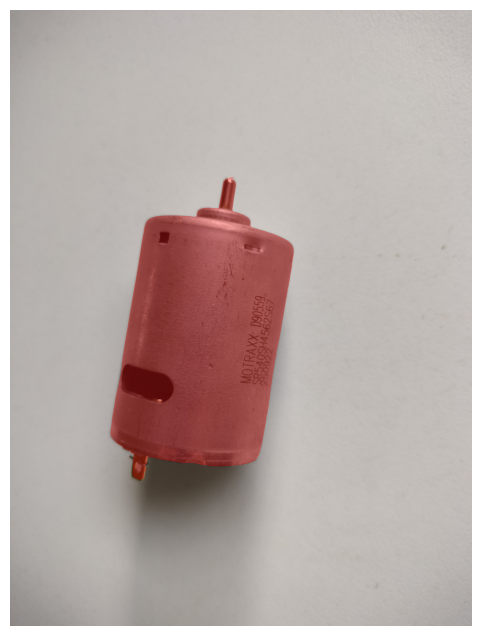

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- paths to your image + label ---
img_path = "/content/drive/MyDrive/sam2_dataset/images/train/IMG20250131094457.jpg"
txt_path = "/content/drive/MyDrive/sam2_dataset/images/train_auto_annotate_labels/IMG20250131094457.txt"

# --- load image ---
img = Image.open(img_path).convert("RGB")
W, H = img.size

# --- read YOLO segmentation file ---
with open(txt_path, "r") as f:
    lines = f.readlines()

# make a copy for drawing
overlay = img.copy()
draw = ImageDraw.Draw(overlay, "RGBA")

for line in lines:
    parts = line.strip().split()
    cls_id = int(parts[0])                   # class id
    coords = list(map(float, parts[1:]))     # polygon coords

    # denormalize to pixel coordinates
    poly = [(coords[i] * W, coords[i+1] * H) for i in range(0, len(coords), 2)]

    # draw polygon (red with transparency)
    draw.polygon(poly, outline="red", fill=(255, 0, 0, 80))
    draw.text((poly[0][0], poly[0][1]-10), f"Class {cls_id}", fill="red")

# --- display ---
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.axis("off")
plt.show()


In [ ]:
from ultralytics.data.annotator import auto_annotate

auto_annotate(
    data="/content/drive/MyDrive/YOLO_Datensatz/images",
    det_model="/content/runs/segment/train4/weights/best.pt",  # your trained model
    sam_model="sam2_b.pt",
    conf=0.35   # optional: adjust if you get too many/too few detections
    ## possible usage of OBB to be considered
)


image 1/1336 /content/drive/MyDrive/YOLO_Datensatz/images/10685-f9cc5-yar-203-2fskf.jpg: 640x640 (no detections), 10.0ms
image 2/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20206.jpg: 480x640 1 Kugellager, 10.0ms
image 3/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104758.jpg: 320x640 1 Kugellager, 1 Motor, 62.6ms
image 4/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104800.jpg: 320x640 1 Kugellager, 1 Motor, 15.8ms
image 5/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104801.jpg: 320x640 1 Kugellager, 1 Motor, 8.9ms
image 6/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104803.jpg: 320x640 1 Kugellager, 1 Motor, 8.9ms
image 7/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104805.jpg: 320x640 1 Kugellager, 8.8ms
image 8/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104807.jpg: 320x640 1 Kugellager, 1 Motor, 8.9ms
image 9/1336 /content/drive/MyDrive/YOLO_Datensatz/images/20250129_104809.jpg: 320x640 1 Ku

In [ ]:
!pip install ultralytics --upgrade
!yolo mode=checks data=/content/drive/MyDrive/YOLO_DataSet/data.yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 918, in entrypoint
    raise ValueError(f"Invalid 'mode={mode}'. Valid modes are {list(MODES)}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'mode=<module 'ultralytics.utils.checks' from '/usr/local/lib/python3.12/dist-packages/ultralytics/utils/checks.py'>'. Valid modes are ['export', 'train', 'benchmark', 'track', 'val', 'predict'].

    Arguments received: ['yolo', 'mode=checks', 'data=/content/drive/MyDrive/YOLO_DataSet/data.yaml']. Ultralytics 'yolo' commands use th

In [ ]:
!yolo task=segment mode=train \
  model=yolo11s-seg.pt \
  data=/content/drive/MyDrive/YOLO_DataSet/data.yaml \
  epochs=150 imgsz=640 batch=16 patience=50

In [ ]:
from ultralytics.data.annotator import auto_annotate

auto_annotate(
    data="/content/drive/MyDrive/removed_flagged/images",
    det_model="/content/runs/segment/train2/weights/best.pt",  # your trained model
    sam_model="sam2_b.pt",
    conf=0.55   # optional: adjust if you get too many/too few detections
)


image 1/696 /content/drive/MyDrive/removed_flagged/images/10685-f9cc5-yar-203-2fskf.jpg: 640x640 (no detections), 20.3ms
image 2/696 /content/drive/MyDrive/removed_flagged/images/20206.jpg: 480x640 (no detections), 62.7ms
image 3/696 /content/drive/MyDrive/removed_flagged/images/20250129_104805.jpg: 320x640 1 Kugellager, 1 Motor, 62.6ms
image 4/696 /content/drive/MyDrive/removed_flagged/images/20250129_104820.jpg: 320x640 1 Kugellager, 1 Motor, 9.4ms
image 5/696 /content/drive/MyDrive/removed_flagged/images/20250129_104830.jpg: 320x640 2 Motors, 9.3ms
image 6/696 /content/drive/MyDrive/removed_flagged/images/20250129_104833.jpg: 320x640 1 Kugellager, 1 Motor, 9.4ms
image 7/696 /content/drive/MyDrive/removed_flagged/images/20250129_104835.jpg: 320x640 1 Kugellager, 1 Motor, 13.4ms
image 8/696 /content/drive/MyDrive/removed_flagged/images/20250129_104853.jpg: 640x320 1 Kugellager, 1 Motor, 74.2ms
image 9/696 /content/drive/MyDrive/removed_flagged/images/20250129_104856.jpg: 640x320 1 Ku

In [ ]:
!yolo task=segment mode=train \
  model=yolo11s-seg.pt \
  data=/content/drive/MyDrive/YOLO_DataSet/data.yaml \
  epochs=150 imgsz=640 batch=16 patience=50

Ultralytics 8.3.193 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/YOLO_DataSet/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspective=0.0, plots=True, 

In [ ]:
!yolo task=segment train \
  model=/content/runs/segment/train2/weights/best.pt \
  data=/content/drive/MyDrive/YOLO_DataSet/data.yaml \
  epochs=120 imgsz=832 batch=16 patience=40 seed=0 \
  cfg=/content/drive/MyDrive/YOLO_DataSet/hyp_thesis.yaml \
  close_mosaic=25 save_period=5 workers=2 device=0

Overriding /usr/local/lib/python3.12/dist-packages/ultralytics/cfg/default.yaml with /content/drive/MyDrive/YOLO_DataSet/hyp_thesis.yaml
WARNING ⚠️ 'mode' argument is missing. Valid modes are ['track', 'predict', 'benchmark', 'train', 'export', 'val']. Using default 'mode=train'.
WARNING ⚠️ 'model' argument is missing. Using default 'model=yolo11n.pt'.
WARNING ⚠️ 'data' argument is missing. Using default 'data=coco8.yaml'.
Ultralytics 8.3.193 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=25, cls=0.5, conf=None, copy_paste=0.35, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco8.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=

In [ ]:
!rm -f /content/drive/MyDrive/YOLO_DataSet/train/labels.cache
!rm -f /content/drive/MyDrive/YOLO_DataSet/valid/labels.cache

In [ ]:
!yolo segment train model=yolo11s-seg.pt data=/content/drive/MyDrive/YOLO_DataSet/data.yaml \
epochs=150 imgsz=832 batch=16 patience=50 seed=0 workers=0 cache=ram name=train_thesis \
degrees=10 translate=0.06 scale=0.60 shear=2.0 perspective=0.0 fliplr=0.50 flipud=0.10 \
hsv_h=0.015 hsv_s=0.80 hsv_v=0.50 mosaic=0.40 mixup=0.10 copy_paste=0.35 close_mosaic=25 save_period=5

Ultralytics 8.3.193 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=25, cls=0.5, conf=None, copy_paste=0.35, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/YOLO_DataSet/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.8, hsv_v=0.5, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=0.4, multi_scale=False, name=train_thesis, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspective=0.0, plots=T

In [ ]:
!ls -lh /content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights

total 1.8G
-rw------- 1 root root 59M Sep  5 19:53 best.pt
-rw------- 1 root root 59M Sep  5 18:05 epoch0.pt
-rw------- 1 root root 59M Sep  5 19:29 epoch100.pt
-rw------- 1 root root 59M Sep  5 19:33 epoch105.pt
-rw------- 1 root root 59M Sep  5 18:14 epoch10.pt
-rw------- 1 root root 59M Sep  5 19:37 epoch110.pt
-rw------- 1 root root 59M Sep  5 19:42 epoch115.pt
-rw------- 1 root root 59M Sep  5 19:46 epoch120.pt
-rw------- 1 root root 59M Sep  5 19:50 epoch125.pt
-rw------- 1 root root 59M Sep  5 19:54 epoch130.pt
-rw------- 1 root root 59M Sep  5 19:57 epoch135.pt
-rw------- 1 root root 59M Sep  5 18:18 epoch15.pt
-rw------- 1 root root 59M Sep  5 18:22 epoch20.pt
-rw------- 1 root root 59M Sep  5 18:26 epoch25.pt
-rw------- 1 root root 59M Sep  5 18:31 epoch30.pt
-rw------- 1 root root 59M Sep  5 18:35 epoch35.pt
-rw------- 1 root root 59M Sep  5 18:39 epoch40.pt
-rw------- 1 root root 59M Sep  5 18:43 epoch45.pt
-rw------- 1 root root 59M Sep  5 18:47 epoch50.pt
-rw------- 1 roo

In [ ]:
!yolo task=segment mode=val \
  model=/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt \
  data=/content/drive/MyDrive/YOLO_DataSet/data.yaml \
  imgsz=832 batch=16


Ultralytics 8.3.193 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,977 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 505.4±274.0 MB/s, size: 14228.5 KB)
val: Scanning /content/drive/MyDrive/YOLO_DataSet/valid/labels.cache... 187 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 187/187 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 0.3it/s 46.7s
                   all        187        247      0.963      0.922      0.987      0.881      0.951      0.955      0.987      0.886
            Kugellager        108        108      0.935      0.935      0.986      0.918      0.928      0.955      0.978      0.889
                 Motor        100        100          1      0.909      0.993       0.94          1      0.935      0.993      0.943
       Schraubenziehe

In [ ]:
from ultralytics.data.annotator import auto_annotate
auto_annotate(
    data="/content/drive/MyDrive/discarded_usages",
    det_model="/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt",
    sam_model="sam2_b.pt",
    conf=0.55, iou=0.55, imgsz=832, max_det=300
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/421 /content/drive/MyDrive/discarded_usages/10685-f9cc5-yar-203-2fskf.jpg: 832x832 1 Kugellager, 32.5ms
image 2/421 /content/drive/MyDrive/discarded_usages/20206.jpg: 640x832 2 Kugellagers, 61.7ms
image 3/421 /content/drive/MyDrive/discarded_usages/20250129_104830.jpg: 384x832 1 Kugellager, 1 Motor, 64.3ms
image 4/421 /content/drive/MyDrive/discarded_usages/20250129_104833.jpg: 384x832 1 Kugellager, 1 Motor, 9.3ms
image 5/421 /content/drive/MyDrive/discarded_usages/20250129_104835.jpg: 384x832 2 Kugellagers, 16.7ms
image 6/421 /content/drive/MyDrive/discarded_usages/20250129_104853.jpg: 384x832 1 Kugellager, 1 Motor, 8.8ms
image 7/421 /content/drive/MyDrive/discarded_usag

In [ ]:
from ultralytics.data.annotator import auto_annotate

# High-precision pass
auto_annotate(
    data="/content/drive/MyDrive/discarded",
    det_model="/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt",
    sam_model="sam2_l.pt",          # or "sam_h.pt" if available
    conf=0.60,                      # stricter: fewer bad boxes
    iou=0.60,                       # stricter NMS for close-by objects
    imgsz=1024,                     # larger boxes help thin shafts/edges
    max_det=150                     # your scenes don’t need 300+
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/280 /content/drive/MyDrive/discarded/20250129_104805.jpg: 480x1024 1 Kugellager, 1 Motor, 147.7ms
image 2/280 /content/drive/MyDrive/discarded/20250129_104820.jpg: 480x1024 1 Schraubenzieher, 19.6ms
image 3/280 /content/drive/MyDrive/discarded/20250129_104935.jpg: 480x1024 1 Kugellager, 22.8ms
image 4/280 /content/drive/MyDrive/discarded/20250129_105241.jpg: 480x1024 1 Kugellager, 1 Motor, 11.4ms
image 5/280 /content/drive/MyDrive/discarded/20250129_105245.jpg: 480x1024 1 Kugellager, 1 Motor, 11.0ms
image 6/280 /content/drive/MyDrive/discarded/20250129_105248.jpg: 480x1024 1 Kugellager, 1 Motor, 17.2ms
image 7/280 /content/drive/MyDrive/discarded/20250129_105250.jpg: 480x

In [ ]:
from ultralytics.data.annotator import auto_annotate

# High-precision pass
auto_annotate(
    data="/content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data",
    det_model="/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt",
    sam_model="sam2_l.pt",          # or "sam_h.pt" if available
    conf=0.60,                      # stricter: fewer bad boxes
    iou=0.60,                       # stricter NMS for close-by objects
    imgsz=1024,                     # larger boxes help thin shafts/edges
    max_det=150                     # your scenes don’t need 300+
)


image 1/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/A-4000827877-01-all.jpg: 1024x1024 1 Schraubenzieher, 43.0ms
image 2/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094220.jpg: 1024x768 1 Motor, 18.1ms
image 3/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094305.jpg: 768x1024 1 Motor, 18.2ms
image 4/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094310.jpg: 768x1024 1 Motor, 17.1ms
image 5/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094318.jpg: 1024x768 1 Motor, 18.1ms
image 6/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094434.jpg: 1024x768 1 Motor, 17.1ms
image 7/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094449.jpg: 1024x768 1 Motor, 17.1ms
image 8/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094457.jpg: 1024x768 1 Motor, 17.1ms
image 9/78 /content/drive/MyDrive/YOLO_Datensatz/YOLO_test_data/IMG20250131094514.jpg: 102

In [ ]:
from ultralytics.data.annotator import auto_annotate

# High-precision pass
auto_annotate(
    data="/content/drive/MyDrive/discarded_copies",
    det_model="/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt",
    sam_model="sam2_l.pt",          # or "sam_h.pt" if available
    conf=0.60,                      # stricter: fewer bad boxes
    iou=0.60,                       # stricter NMS for close-by objects
    imgsz=1024,                     # larger boxes help thin shafts/edges
    max_det=150                     # your scenes don’t need 300+
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/202 /content/drive/MyDrive/discarded_copies/20206.jpg: 768x1024 1 Kugellager, 1497.6ms
image 2/202 /content/drive/MyDrive/discarded_copies/20250129_104820.jpg: 480x1024 1 Kugellager, 1 Motor, 602.5ms
image 3/202 /content/drive/MyDrive/discarded_copies/20250129_104830.jpg: 480x1024 1 Kugellager, 1 Motor, 585.3ms
image 4/202 /content/drive/MyDrive/discarded_copies/20250129_104859.jpg: 480x1024 1 Kugellager, 1 Motor, 646.0ms
image 5/202 /content/drive/MyDrive/discarded_copies/20250129_104919.jpg: 480x1024 2 Kugellagers, 1 Motor, 642.9ms
image 6/202 /content/drive/MyDrive/discarded_copies/20250129_104935.jpg: 480x1024 1 Kugellager, 1 Motor, 669.7ms
image 7/202 /content/drive/

In [ ]:
from ultralytics.data.annotator import auto_annotate

# High-precision pass
auto_annotate(
    data="/content/drive/MyDrive/New_Images",
    det_model="/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt",
    sam_model="sam2_l.pt",          # or "sam_h.pt" if available
    conf=0.65,                      # stricter: fewer bad boxes
    iou=0.60,                       # stricter NMS for close-by objects
    imgsz=1024,                     # larger boxes help thin shafts/edges
    max_det=150                     # your scenes don’t need 300+
)


image 1/266 /content/drive/MyDrive/New_Images/20250129_105524.jpg: 480x1024 1 Kugellager, 1 Motor, 97.5ms
image 2/266 /content/drive/MyDrive/New_Images/IMG20250131095101.jpg: 1024x768 1 Motor, 101.6ms
image 3/266 /content/drive/MyDrive/New_Images/IMG_3018.JPG: 1024x1024 1 Motor, 44.4ms
image 4/266 /content/drive/MyDrive/New_Images/IMG_3019.JPG: 1024x1024 1 Motor, 43.1ms
image 5/266 /content/drive/MyDrive/New_Images/IMG_3020.JPG: 1024x1024 1 Motor, 22.5ms
image 6/266 /content/drive/MyDrive/New_Images/IMG_3021.JPG: 1024x1024 1 Motor, 22.3ms
image 7/266 /content/drive/MyDrive/New_Images/IMG_3022.JPG: 1024x1024 1 Motor, 22.6ms
image 8/266 /content/drive/MyDrive/New_Images/IMG_3023.JPG: 1024x1024 1 Motor, 22.4ms
image 9/266 /content/drive/MyDrive/New_Images/IMG_3024.JPG: 1024x1024 1 Kugellager, 1 Motor, 22.1ms
image 10/266 /content/drive/MyDrive/New_Images/IMG_3025.JPG: 1024x1024 1 Motor, 22.3ms
image 11/266 /content/drive/MyDrive/New_Images/IMG_3026.JPG: 1024x1024 1 Motor, 22.1ms
image 12

In [ ]:
from ultralytics.data.annotator import auto_annotate

# High-precision pass
auto_annotate(
    data="/content/drive/MyDrive/NEW_IMAGES/unlabeled_images",
    det_model="/content/drive/MyDrive/YOLO_Runs/segment/train_thesis/weights/best.pt",
    sam_model="sam2_l.pt",          # or "sam_h.pt" if available
    conf=0.65,                      # stricter: fewer bad boxes
    iou=0.60,                       # stricter NMS for close-by objects
    imgsz=1024,                     # larger boxes help thin shafts/edges
    max_det=150                     # your scenes don’t need 300+
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/48 /content/drive/MyDrive/NEW_IMAGES/unlabeled_images/IMG_3024.JPG: 1024x1024 1 Kugellager, 1 Motor, 43.0ms
image 2/48 /content/drive/MyDrive/NEW_IMAGES/unlabeled_images/IMG_3027.JPG: 1024x1024 1 Kugellager, 1 Motor, 21.8ms
image 3/48 /content/drive/MyDrive/NEW_IMAGES/unlabeled_images/IMG_3037.JPG: 1024x1024 1 Kugellager, 1 Motor, 21.8ms
image 4/48 /content/drive/MyDrive/NEW_IMAGES/unlabeled_images/IMG_3043.JPG: 1024x768 2 Kugellagers, 63.5ms
image 5/48 /content/drive/MyDrive/NEW_IMAGES/unlabeled_images/IMG_3047.JPG: 1024x768 2 Kugellagers, 16.9ms
image 6/48 /content/drive/MyDrive/NEW_IMAGES/unlabeled_images/IMG_3050.JPG: 768x1024 2 Kugellagers, 90.1ms
image 7/48 /content

In [ ]:
! gdown --id https://drive.google.com/drive/folders/17f57NrjT8P-OMkdO7WiPx_JlayjhNLhE?usp=sharing

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=https://drive.google.com/drive/folders/17f57NrjT8P-OMkdO7WiPx_JlayjhNLhE?usp=sharing

but Gdown can't. Please check connections and permissions.
